In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jobathon-analytics-vidhya-health-insurance/sample_submission.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Test_data_dictionary.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Train_data_dictionary.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Train.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Test.csv


# **Rank in top 15% on Private Leader Board**

### Hope This Notebook Helps others prepare for the same 

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# pd.set_option('display.max_rows',None)
# pd.set_option('display.max_columns',None)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score

In [3]:
train=pd.read_csv('/kaggle/input/jobathon-analytics-vidhya-health-insurance/Train.csv')
test=pd.read_csv('/kaggle/input/jobathon-analytics-vidhya-health-insurance/Test.csv')
sub=pd.read_csv('/kaggle/input/jobathon-analytics-vidhya-health-insurance/sample_submission.csv')

In [4]:
sub.head()

,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0


In [5]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [6]:
train['Diff']=train['Upper_Age']-train['Lower_Age']
test['Diff']=test['Upper_Age']-test['Lower_Age']

def set_range_age(x):
    if(x<15):
        return 1
    elif((x>=15) and (x<30)):
        return 2
    elif(x>=30 and x<45):
        return 3
    elif(x>=45):
        return 4
    
train['New']=train['Diff'].apply(set_range_age)
test['New']=test['Diff'].apply(set_range_age)

In [7]:
train['New'].value_counts()

1    48282
2     1415
3     1038
4      147
Name: New, dtype: int64

In [8]:
train.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
Diff                           0
New                            0
dtype: int64

In [9]:
len(train)

50882

In [10]:
a = train.isnull().sum()/len(train)*100
a[a>0]

Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
dtype: float64

In [11]:
a = test.isnull().sum()/len(test)*100
a[a>0]

Health Indicator           23.054345
Holding_Policy_Duration    39.454254
Holding_Policy_Type        39.454254
dtype: float64

In [12]:
train.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Diff,New
count,50882.000000,50882.000000,50882.000000,50882.000000,30631.000000,50882.000000,50882.000000,50882.000000,50882.000000,50882.000000
mean,25441.500000,1732.788707,44.856275,42.738866,2.439228,15.115188,14183.950069,0.239947,2.117409,1.077277
std,14688.512535,1424.081652,17.310271,17.319375,1.025923,6.340663,6590.074873,0.427055,6.865406,0.359781
min,1.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2280.000000,0.000000,0.000000,1.000000
25%,12721.250000,523.000000,28.000000,27.000000,1.000000,12.000000,9248.000000,0.000000,0.000000,1.000000
50%,25441.500000,1391.000000,44.000000,40.000000,3.000000,17.000000,13178.000000,0.000000,0.000000,1.000000
75%,38161.750000,2667.000000,59.000000,57.000000,3.000000,20.000000,18096.000000,0.000000,0.000000,1.000000
max,50882.000000,6194.000000,75.000000,75.000000,4.000000,22.000000,43350.400000,1.000000,59.000000,4.000000


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
 14  Diff                  

In [14]:
train.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response', 'Diff', 'New'],
      dtype='object')

In [15]:
print(len(train))

50882


In [16]:
for i in train.columns:
    print(f'Column :{i} Number of unique columns:{train[i].nunique()}')  

Column :ID Number of unique columns:50882
Column :City_Code Number of unique columns:36
Column :Region_Code Number of unique columns:5316
Column :Accomodation_Type Number of unique columns:2
Column :Reco_Insurance_Type Number of unique columns:2
Column :Upper_Age Number of unique columns:58
Column :Lower_Age Number of unique columns:60
Column :Is_Spouse Number of unique columns:2
Column :Health Indicator Number of unique columns:9
Column :Holding_Policy_Duration Number of unique columns:15
Column :Holding_Policy_Type Number of unique columns:4
Column :Reco_Policy_Cat Number of unique columns:22
Column :Reco_Policy_Premium Number of unique columns:6977
Column :Response Number of unique columns:2
Column :Diff Number of unique columns:60
Column :New Number of unique columns:4


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='City_Code', ylabel='count'>

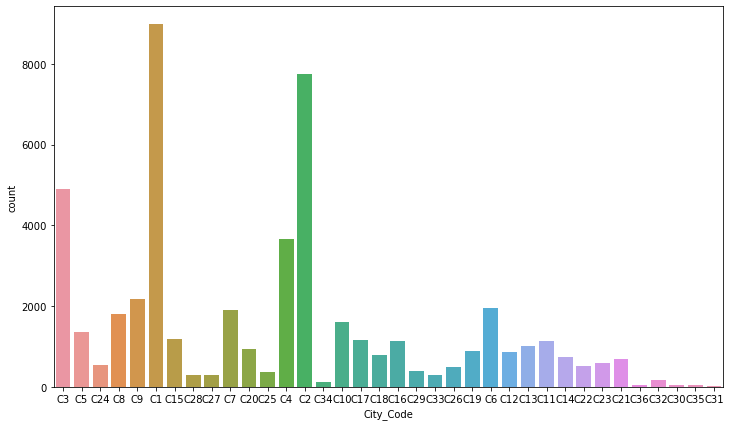

In [17]:
plt.figure(figsize=(12,7))
sns.countplot(train['City_Code'])

In [18]:
train['City_Code'].nunique()

36

In [19]:
train['City_Code'].value_counts()

C1     8973
C2     7747
C3     4889
C4     3671
C9     2185
C6     1950
C7     1910
C8     1806
C10    1611
C5     1364
C15    1186
C17    1159
C11    1147
C16    1135
C13    1005
C20     926
C19     899
C12     868
C18     797
C14     746
C21     679
C23     587
C24     553
C22     516
C26     499
C29     387
C25     366
C27     295
C33     286
C28     285
C32     160
C34     130
C30      58
C35      56
C36      36
C31      15
Name: City_Code, dtype: int64

In [20]:
# train['Region_Code'].value_counts()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Upper_Age', ylabel='Density'>

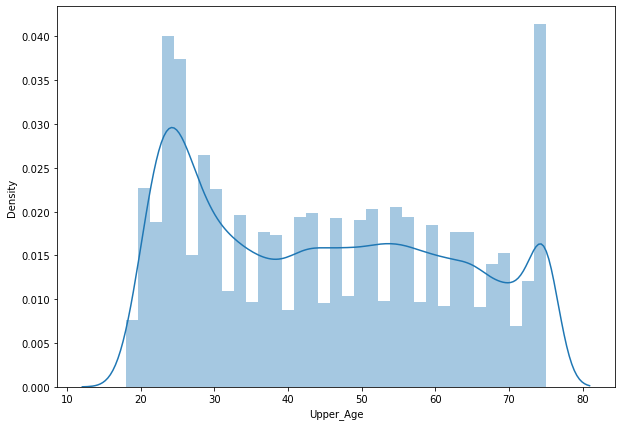

In [21]:
plt.figure(figsize=(10,7))
sns.distplot(train['Upper_Age'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Lower_Age', ylabel='Density'>

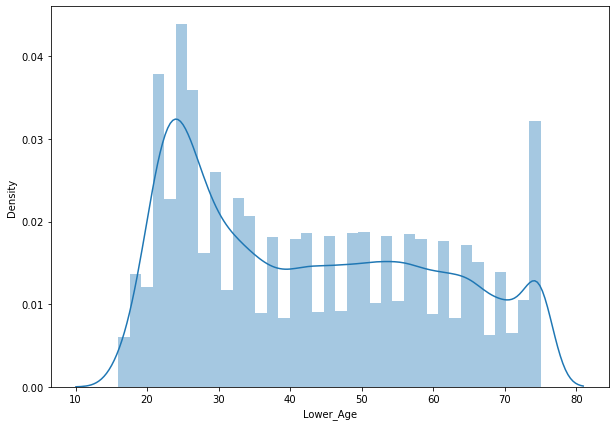

In [22]:
plt.figure(figsize=(10,7))
sns.distplot(train['Lower_Age'])

In [23]:
train['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [24]:
train.groupby('City_Code')['Health Indicator'].value_counts()

City_Code  Health Indicator
C1         X1                  2235
           X2                  1792
           X3                  1092
           X4                  1077
           X5                   433
                               ... 
C9         X5                    65
           X6                    46
           X7                     8
           X9                     7
           X8                     6
Name: Health Indicator, Length: 287, dtype: int64

c28=x2
c31=x2
c35=x3
c36=x2

In [25]:
def set_health_indicator(x):
    city=x[0]
    health=x[1]
    if pd.isnull(health):
        if (city=='C28') | (city=='C31') | (city=='C36'):
            return 'X2'
        elif city=='C35':
            return 'X3'
        else:
            return 'X1'
    else:
        return health
train['Health Indicator']=train[['City_Code','Health Indicator']].apply(set_health_indicator,axis=1)
test['Health Indicator']=test[['City_Code','Health Indicator']].apply(set_health_indicator,axis=1)

In [26]:
train.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator               0
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
Diff                           0
New                            0
dtype: int64

In [27]:
train['Holding_Policy_Duration'].value_counts()

1.0     4499
14+     4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64

In [28]:
train.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator               0
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
Diff                           0
New                            0
dtype: int64

In [29]:
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].apply(lambda x:15.0 if x =='14+' else float(x))
test['Holding_Policy_Duration']=test['Holding_Policy_Duration'].apply(lambda x:15.0 if x =='14+' else float(x))

In [30]:
train['Holding_Policy_Duration'].value_counts()

1.0     4499
15.0    4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64

In [31]:
train['Holding_Policy_Duration'].describe()

count    30631.000000
mean         6.156769
std          4.758830
min          1.000000
25%          2.000000
50%          5.000000
75%          9.000000
max         15.000000
Name: Holding_Policy_Duration, dtype: float64

In [32]:
# train['Holding_Policy_Duration'].fillna(5.0,inplace=)

In [33]:
train['Holding_Policy_Duration'].fillna(5.0,inplace=True)
test['Holding_Policy_Duration'].fillna(5.0,inplace=True)

In [34]:
train.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator               0
Holding_Policy_Duration        0
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
Diff                           0
New                            0
dtype: int64

In [35]:
train['Holding_Policy_Type'].value_counts()

3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64

In [36]:
train.groupby('City_Code')['Holding_Policy_Type'].value_counts().head()

City_Code  Holding_Policy_Type
C1         3.0                    2415
           1.0                    1592
           4.0                    1007
           2.0                     729
C10        3.0                     370
Name: Holding_Policy_Type, dtype: int64

In [37]:
list_city=['c12','c15','c17','c18','c19','c24']
def set_Holding_Policy(x):
    city=x[0]
    policy=x[1]
    if pd.isnull(policy):
        if (city in list_city):
            return 1
        else:
            return 3
    return policy
train['Holding_Policy_Type']=train[['City_Code','Holding_Policy_Type']].apply(set_Holding_Policy,axis=1)
test['Holding_Policy_Type']=test[['City_Code','Holding_Policy_Type']].apply(set_Holding_Policy,axis=1)

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         50882 non-null  object 
 9   Holding_Policy_Duration  50882 non-null  float64
 10  Holding_Policy_Type      50882 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
 14  Diff                  

In [39]:
train['Response'].value_counts()

0    38673
1    12209
Name: Response, dtype: int64

In [40]:
for i in train.columns:
    print(f'Column :{i} Number of unique columns:{train[i].nunique()}')  

Column :ID Number of unique columns:50882
Column :City_Code Number of unique columns:36
Column :Region_Code Number of unique columns:5316
Column :Accomodation_Type Number of unique columns:2
Column :Reco_Insurance_Type Number of unique columns:2
Column :Upper_Age Number of unique columns:58
Column :Lower_Age Number of unique columns:60
Column :Is_Spouse Number of unique columns:2
Column :Health Indicator Number of unique columns:9
Column :Holding_Policy_Duration Number of unique columns:15
Column :Holding_Policy_Type Number of unique columns:4
Column :Reco_Policy_Cat Number of unique columns:22
Column :Reco_Policy_Premium Number of unique columns:6977
Column :Response Number of unique columns:2
Column :Diff Number of unique columns:60
Column :New Number of unique columns:4


In [41]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Diff,New
0,1,C3,3213,Rented,Individual,36,36,No,X1,15.0,3.0,22,11628.0,0,0,1
1,2,C5,1117,Owned,Joint,75,22,No,X2,5.0,3.0,22,30510.0,0,53,4
2,3,C5,3732,Owned,Individual,32,32,No,X1,1.0,1.0,19,7450.0,1,0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,15.0,3.0,19,17780.0,0,4,1
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0,0,1


<AxesSubplot:>

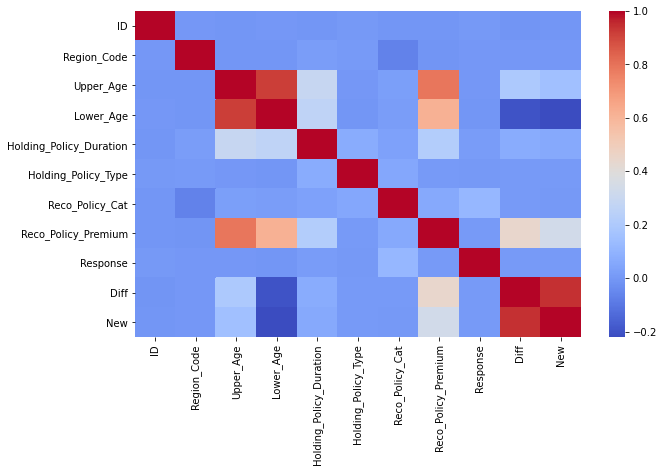

In [42]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(),cmap='coolwarm')

In [43]:
columns_to_drop=['ID','Region_Code','Reco_Policy_Premium','Diff','Upper_Age','Lower_Age']
dummies_columns=['City_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse'
                 ,'Holding_Policy_Type','Reco_Policy_Cat']
label_encode=['Health Indicator']

In [44]:
# train[(train['Is_Spouse']=='Yes')&(train['Reco_Insurance_Type']=='Individual')]

In [45]:
# a=train[(train['Is_Spouse']=='No')&(train['Reco_Insurance_Type']=='Joint')].index
# train.drop(a,inplace=True)

In [46]:
train.drop(columns=columns_to_drop,inplace=True)
test.drop(columns=columns_to_drop,inplace=True)

In [47]:
train_1=train.copy()
train_1=pd.get_dummies(train_1,drop_first=True,columns=dummies_columns)
test_1=test.copy()
test_1=pd.get_dummies(test_1,drop_first=True,columns=dummies_columns)

le=LabelEncoder()
for col in label_encode:
    train_1[col]=le.fit_transform(train_1[col])
    test_1[col]=le.transform(test_1[col])

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [48]:
train_1.shape

(50882, 66)

In [49]:
X=train_1.drop(columns=['Response'])
y=train_1['Response']

In [50]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [51]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
test_1=scaler.transform(test_1)

In [52]:
# cvs_random=cross_val_score(RandomForestClassifier(),X=X_train,y=y_train,cv=5,scoring='accuracy')
# print(cvs_random.mean())
# print(cvs_random.std())

In [53]:
# cvs_random=cross_val_score(DecisionTreeClassifier(),X=X_train,y=y_train,cv=5,scoring='accuracy')
# print(cvs_random.mean())
# print(cvs_random.std())

In [54]:
# cvs_random=cross_val_score(LogisticRegression(),X=X_train,y=y_train,cv=5,scoring='accuracy')
# print(cvs_random.mean())
# print(cvs_random.std())

In [55]:
# cvs_random=cross_val_score(XGBClassifier(),X=X_train,y=y_train,cv=5)
# print(cvs_random.mean())
# print(cvs_random.std())

In [56]:
# sm = SMOTE(random_state = 2) 
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) 

# model=LogisticRegression(solver="liblinear")

# model.fit(X_train_res,y_train_res)
# pred_logistic=model.predict_proba(X_test)[:, 1]

# roc_auc_score(y_test,pred_logistic)

In [57]:
# model=LogisticRegression(solver="liblinear")

# model.fit(X_train,y_train)
# pred_logistic=model.predict_proba(X_test)[:, 1]

# roc_auc_score(y_test,pred_logistic)

In [58]:
# model=RandomForestClassifier()

# model.fit(X_train,y_train)
# pred_random=model.predict_proba(X_test)[:, 1]

# roc_auc_score(y_test,pred_random)

In [59]:
# model=DecisionTreeClassifier()

# model.fit(X_train,y_train)
# pred_decision=model.predict_proba(X_test)[:, 1]

# roc_auc_score(y_test,pred_decision)

In [60]:
# test_predictions=model.predict_proba(test_1)[:, 1]

# sub['Response']=test_predictions

# sub.to_csv('JOB-A-THON-LOGISTICS(PREDICTIONS)-1.csv',index=False)

In [61]:
# from sklearn.model_selection import GridSearchCV
# param_test1 = {'n_estimators':range(20,81,10)}
# gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
# param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
# gsearch1.fit(X_train,y_train)

In [62]:
# gsearch1.get_params, gsearch1.best_params_, gsearch1.best_score_

In [63]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import StratifiedKFold
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)
# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# # Here we go
# # start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X_train, y_train)
# # timer(start_time) # timing ends here for "start_time" variable

# random_search.best_params_

In [64]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=1.5,
 subsample=0.6,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb1.fit(X_train,y_train)

# model=XGBClassifier()

xgb1.fit(X_train,y_train)
pred_xgb=xgb1.predict_proba(X_test)[:, 1]

roc_auc_score(y_test,pred_xgb)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:38:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:39:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6630047606517206

In [65]:
# train[train['Diff']>0]['Diff'].describe()

In [66]:
# train['Diff']=train['Upper_Age']-train['Lower_Age']
# pd.cut(train['Diff'],bins=4)

In [67]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
# gsearch1.fit(X_train,y_train)
# gsearch1.best_estimator_, gsearch1.best_params_, gsearch1.best_score_

In [68]:
# sm = SMOTE(random_state = 2) 
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) 
# from imblearn.under_sampling import NearMiss 
# nr = NearMiss() 
  
# X_train_res, y_train_res = nr.fit_resample(X_train, y_train.ravel())

# model=XGBClassifier()

# model.fit(X_train_res,y_train_res)
# pred_xgb=model.predict_proba(X_test)[:, 1]

# roc_auc_score(y_test,pred_xgb)

In [69]:
# model.predict_proba(test_1)[:,1]

In [70]:
test_predictions=xgb1.predict_proba(test_1)[:, 1]

sub['Response']=test_predictions

sub.to_csv('JOB-A-THON-XGB(PREDICTIONS)-1.csv',index=False)

In [71]:
sub

,ID,Response
0,50883,0.244737
1,50884,0.164278
2,50885,0.206349
3,50886,0.181954
4,50887,0.234947
...,...,...
21800,72683,0.107873
21801,72684,0.383770
21802,72685,0.073992
21803,72686,0.401287
